## Automated Tree Cover Loss QC

In [1]:
import os
import math
import numpy as np
import rasterio as rio
import fiona
import pandas as pd
import geopandas as gpd
import requests
from utils import parse_bounds, concatenate_windows
from tqdm.notebook import tqdm
from rasterio.windows import from_bounds
from rasterstats import zonal_stats
from matplotlib import pyplot as plt

In [2]:
# data config
DATA_DIR = '../test'
OUT_DIR = '../output'
SHP_FN = 'sumatera_berat.shp'
treecover_threshold = 30
contextual_layers = [
    #'birdlife_alliance_for_zero_extinction_sites',
    'idn_forest_moratorium',
    #'wdpa_protected_areas'
]

shp_fp = os.path.join(DATA_DIR, SHP_FN)

In [3]:
# create directories
if not os.path.exists(OUT_DIR):
    os.mkdir(OUT_DIR)

if not os.path.exists('tmp'):
    os.mkdir('tmp')

#### Get admin area bounds

Use bounds to read a window containing the admin zone from raster tiles

In [4]:
with fiona.open(shp_fp) as src:
    bounds = src.bounds
bounds

(98.59617614746116, -4.016389846801758, 101.88611602783205, 0.9085190296172749)

In [5]:
X_list, Y_list = parse_bounds(bounds)
X_list, Y_list

(['090E', '100E'], ['00N', '10N'])

#### Intersect admin area with contextual layers

In [6]:
def get_s3_asset_uri(dataset):
    res = requests.get(f'https://data-api.globalforestwatch.org/dataset/{dataset}/latest/assets?asset_type=ESRI Shapefile')
    return res.json()['data'][0]['asset_uri']

In [11]:
def intersect_layers(layers, bounds, shp_fp):
    # parse for s3 paths
    s3_paths = [get_s3_asset_uri(layer) for layer in layers]
    
    # read contextual layers within bounds of admin area
    contextual_gdfs = []
    for s3_path in s3_paths:
        gdf = gpd.read_file(
            filename=f'zip+{s3_path}',
            bbox=bounds
        )
        contextual_gdfs.append(gdf)
    
    # intersect all layers
    intersected_gdf = gpd.read_file(shp_fp)
    for contextual_gdf in contextual_gdfs:
        try:
            intersected_gdf = gpd.overlay(intersected_gdf, contextual_gdf, how='intersection')
        except:
            continue
    
    # dissolve and save to tmp
    dissolved = gpd.GeoSeries(intersected_gdf.geometry).unary_union
    dissolved_gs = gpd.GeoSeries(dissolved)
    dissolved_gs.to_file(os.path.join('tmp', 'dissolved_intersection.shp'))
    
    return dissolved

In [12]:
intersection = intersect_layers(contextual_layers, bounds, shp_fp)

#### Threshold tree cover density

Generate binary mask array from the tree cover density tile

In [15]:
tcd_arrs = []
for Y in Y_list:
    for X in X_list:
        with rio.open(f's3://gfw-data-lake/umd_tree_cover_density_2000/v1.6/raster/epsg-4326/10/40000/percent/geotiff/{Y}_{X}.tif') as src:
            window = from_bounds(
                bounds[0],
                bounds[1],
                bounds[2],
                bounds[3],
                src.transform
            )
            tcd_arrs.append(src.read(1, window=window))
            win_affine = src.window_transform(window)
            
            print(f'Extracted window for {Y}, {X}')

Extracted window for 00N, 090E
Extracted window for 00N, 100E
Extracted window for 10N, 090E
Extracted window for 10N, 100E


In [16]:
tcd_arr = concatenate_windows(tcd_arrs, X_list, Y_list)

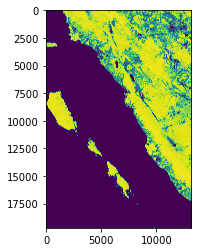

In [17]:
plt.imshow(tcd_arr)

In [18]:
# reclassify using binary threshold
tcd_arr_mask = tcd_arr.copy()
tcd_arr_mask[np.where( tcd_arr <= treecover_threshold )] = 0
tcd_arr_mask[np.where( tcd_arr > treecover_threshold )] = 1

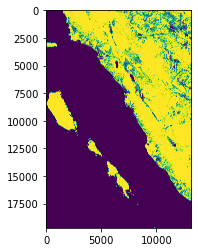

In [19]:
plt.imshow(tcd_arr_mask)

#### Set area array

Read area array and mask by tree cover density threshold

In [20]:
area_arrs = []
for Y in Y_list:
    for X in X_list:
        with rio.open(f's3://gfw-files/2018_update/area/{Y}_{X}.tif') as src:
            area_arr = src.read(1, window=from_bounds(
                bounds[0],
                bounds[1],
                bounds[2],
                bounds[3],
                src.transform
            ))
        area_arrs.append(area_arr)
        
        print(f'Extracted window for {Y}, {X}')

Extracted window for 00N, 090E
Extracted window for 00N, 100E
Extracted window for 10N, 090E
Extracted window for 10N, 100E


In [21]:
area_arr = concatenate_windows(area_arrs, X_list, Y_list)

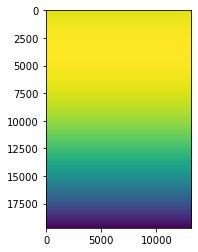

In [22]:
plt.imshow(area_arr)

In [23]:
# mask by treecover threshold array
area_mask = np.multiply(tcd_arr_mask, area_arr)

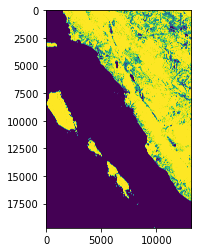

In [24]:
plt.imshow(area_mask)

#### Mask tree cover loss

Read tree cover loss from window and mask using tree cover density threshold

In [25]:
# read as np array from bounds
tcl_arrs = []
for Y in Y_list:
    for X in X_list:
        with rio.open(f's3://gfw-data-lake/umd_tree_cover_loss/v1.7/raster/epsg-4326/10/40000/year/geotiff/{Y}_{X}.tif') as src:
            tcl_arr = src.read(1, window=from_bounds(
                bounds[0],
                bounds[1],
                bounds[2],
                bounds[3],
                src.transform
        ))
        
        tcl_arrs.append(tcl_arr)
        print(f'Extracted window for tree cover loss tile: {Y}, {X}')

Extracted window for tree cover loss tile: 00N, 090E
Extracted window for tree cover loss tile: 00N, 100E
Extracted window for tree cover loss tile: 10N, 090E
Extracted window for tree cover loss tile: 10N, 100E


In [26]:
tcl_arr = concatenate_windows(tcl_arrs, X_list, Y_list)

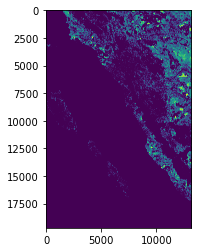

In [27]:
plt.imshow(tcl_arr)

In [28]:
# mask tree cover loss by treecover threshold
tcl_masked = np.multiply(tcd_arr_mask, tcl_arr)

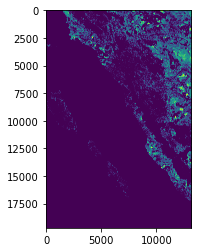

In [29]:
plt.imshow(tcl_masked)

#### Compute zonal statistics for admin boundary

In [30]:
loss_by_year_ha = {}

for year in tqdm(range(1,20)):
    
    # copy thresholded tree cover loss array
    tcl_arr_year = tcl_masked.copy()
    
    # mask by current year
    tcl_arr_year[np.where( tcl_masked != year )] = 0
    tcl_arr_year[np.where( tcl_masked == year )] = 1
    
    # convert to ha using area mask
    tcl_arr_year_area = np.multiply(area_mask, tcl_arr_year) / 10000
    
    # compute zonal stats for admin area
    zstats = zonal_stats(
        os.path.join('tmp', 'dissolved_intersection.shp'),
        tcl_arr_year_area,
        stats='sum',
        affine=win_affine,
        all_touched=False,
        nodata=-999
    )
    
    # log
    annual_loss = zstats[0]['sum']
    print(f'TCL in {year + 2000}: {int(annual_loss)} ha')
    loss_by_year_ha[year + 2000] = annual_loss

TCL in 2001: 1972 ha
TCL in 2002: 2345 ha
TCL in 2003: 1450 ha
TCL in 2004: 4401 ha
TCL in 2005: 4064 ha
TCL in 2006: 4625 ha
TCL in 2007: 8235 ha
TCL in 2008: 6478 ha
TCL in 2009: 7371 ha
TCL in 2010: 5198 ha
TCL in 2011: 7393 ha
TCL in 2012: 7416 ha
TCL in 2013: 4371 ha
TCL in 2014: 5881 ha
TCL in 2015: 4246 ha
TCL in 2016: 8524 ha
TCL in 2017: 12007 ha
TCL in 2018: 9018 ha
TCL in 2019: 5637 ha



#### Save as CSV

In [31]:
loss_df = pd.DataFrame.from_dict(loss_by_year_ha, orient='index')
loss_df = loss_df.rename(columns={0:'area_ha'})
loss_df['threshold'] = f'{treecover_threshold}%'

In [32]:
loss_df.to_csv(os.path.join(
    OUT_DIR, 
    f'{SHP_FN[:-4]}_tree_cover_loss_ha.csv'),
    index_label='year'
)

In [33]:
loss_df

,area_ha,threshold
2001,1972.135733,30%
2002,2345.704825,30%
2003,1450.340677,30%
2004,4401.590406,30%
2005,4064.267259,30%
2006,4625.856012,30%
2007,8235.277610,30%
2008,6478.430485,30%
2009,7371.480741,30%
2010,5198.052611,30%
